In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, between

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")
conn = engine.connect()

engine.execute('select * from measurement limit 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [5]:
# reflect the tables
base = automap_base()
base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = pd.read_sql('select max(date) from measurement', conn)
recent_date.rename(columns = {'max(date)' : 'Most Recent Date'}, inplace = True)
recent_date.set_index('Most Recent Date', inplace = True)
recent_date

""
Most Recent Date
2017-08-23


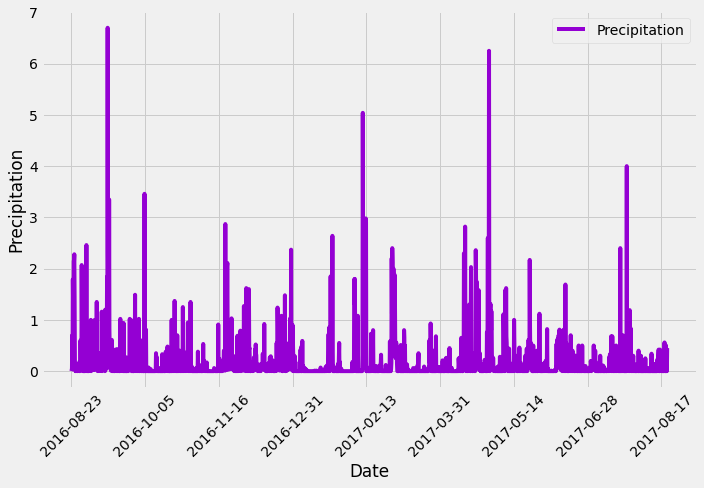

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.


# Perform a query to retrieve the data and precipitation scores

prcp_scores = pd.read_sql(
    '''
    select 
    date, 
    prcp 
    from Measurement 
    where date > date('2017-08-23', '-366 day')
    ''', 
    conn
).dropna()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_scores.rename(columns = {'date' : 'Date', 'prcp' : 'Precipitation'}, inplace = True)
prcp_scores.sort_values(by = 'Date', inplace = True)
prcp_scores.set_index('Date', inplace = True)
prcp_scores

# Use Pandas Plotting with Matplotlib to plot the data

prcp_plot = prcp_scores.plot(color = 'darkviolet', rot = 45, figsize = (10, 7))
prcp_plot.set_ylabel('Precipitation')
prcp_plot.set_xlabel('Date')
prcp_plot.legend(loc = 'best')
plt.tight_layout()
plt.savefig('Images/precipitation.png')
plt.show()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_scores.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
num_stations = len(pd.read_sql('select station from Station', conn))
num_stations_df = pd.DataFrame([{'Total Stations' : num_stations}]).set_index('Total Stations')
num_stations_df


""
Total Stations
9


In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

pd.read_sql(
    '''
    select
    s.name as 'Station',
    s.station as 'Station ID',
    count (m.station) as 'Station Count'
    from Station s
    inner join Measurement m on s.station = m.station
    group by s.name
    order by count (m.station) desc
    ''',
    conn
).set_index('Station').dropna()


,Station ID,Station Count
Station,,
"WAIHEE 837.5, HI US",USC00519281,2772
"WAIKIKI 717.2, HI US",USC00519397,2724
"KANEOHE 838.1, HI US",USC00513117,2709
"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,2669
"MANOA LYON ARBO 785.2, HI US",USC00516128,2612
"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,2202
"HONOLULU OBSERVATORY 702.2, HI US",USC00511918,1979
"PEARL CITY, HI US",USC00517948,1372
"UPPER WAHIAWA 874.3, HI US",USC00518838,511


In [14]:
pd.read_sql('select * from measurement', conn)

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

pd.read_sql(
    '''
    select
    s.station as 'Station ID',
    s.name as 'Station',
    min(m.tobs) as 'Lowest Temperature',
    max(m.tobs) as 'Highest Temperature',
    avg(m.tobs) as 'Average Temperature'
    from Station s
    inner join Measurement m on s.station = m.station
    where s.station = 'USC00519281'
    group by s.name
    ''',
    conn
).set_index('Station ID')


,Station,Lowest Temperature,Highest Temperature,Average Temperature
Station ID,,,,
USC00519281,"WAIHEE 837.5, HI US",54.0,85.0,71.663781


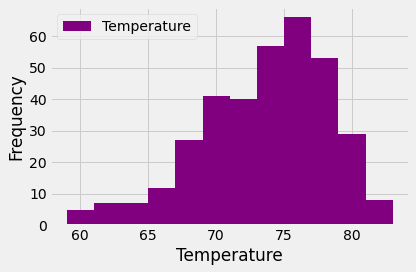

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

waihee = pd.read_sql(
    '''
    select
    s.station as 'Station ID',
    s.name as 'Station',
    m.date as 'Date',
    m.tobs as 'Temperature'
    from Station s
    inner join Measurement m on s.station = m.station
    where s.station = 'USC00519281'
    and m.date > date('2017-08-23', '-366 day')
    group by m.date
    ''',
    conn
).set_index('Date')

waihee.plot(kind = 'hist', color = 'purple', bins = 12).set_xlabel('Temperature')
plt.tight_layout()
plt.savefig('Images/station-histogram.png')
plt.show()


# Bonus 1

In [17]:
measurement_df = pd.read_sql('select * from Measurement', conn)
station_df = pd.read_sql('select * from Station', conn)
measurement_df = measurement_df.astype({'date' : 'datetime64'})
measurement_df.dtypes

id                  int64
station            object
date       datetime64[ns]
prcp              float64
tobs              float64
dtype: object

In [18]:
measurement_df.set_index('date', inplace = True)
measurement_df

,id,station,prcp,tobs
date,,,,
2010-01-01,1,USC00519397,0.08,65.0
2010-01-02,2,USC00519397,0.00,63.0
2010-01-03,3,USC00519397,0.00,74.0
2010-01-04,4,USC00519397,0.00,76.0
2010-01-06,5,USC00519397,NaN,73.0
...,...,...,...,...
2017-08-19,19546,USC00516128,0.09,71.0
2017-08-20,19547,USC00516128,NaN,78.0
2017-08-21,19548,USC00516128,0.56,76.0


In [19]:
measurement_df.tobs.max()

87.0

In [20]:
measurement_df.tobs.min()

53.0

In [21]:
june_df = measurement_df[measurement_df.index.month == 6]
june_df


,id,station,prcp,tobs
date,,,,
2010-06-01,134,USC00519397,0.00,78.0
2010-06-02,135,USC00519397,0.01,76.0
2010-06-03,136,USC00519397,0.00,78.0
2010-06-04,137,USC00519397,0.00,76.0
2010-06-05,138,USC00519397,0.00,77.0
...,...,...,...,...
2017-06-26,19493,USC00516128,0.02,79.0
2017-06-27,19494,USC00516128,0.10,74.0
2017-06-28,19495,USC00516128,0.02,74.0


In [22]:
dec_df = measurement_df[measurement_df.index.month == 12]
dec_df


,id,station,prcp,tobs
date,,,,
2010-12-01,306,USC00519397,0.04,76.0
2010-12-03,307,USC00519397,0.00,74.0
2010-12-04,308,USC00519397,0.00,74.0
2010-12-06,309,USC00519397,0.00,64.0
2010-12-07,310,USC00519397,0.00,64.0
...,...,...,...,...
2016-12-27,19324,USC00516128,0.14,71.0
2016-12-28,19325,USC00516128,0.14,71.0
2016-12-29,19326,USC00516128,1.03,69.0


In [23]:
june_avg = np.mean(june_df['tobs'])
dec_avg = np.mean(dec_df['tobs'])
print(june_avg)
print(dec_avg)

74.94411764705882
71.04152933421226


In [24]:
from scipy import stats
# This will be a two sample t-test as the amount of data collected 
#in June is different from the amount of data collected in December
stats.ttest_ind(june_df['tobs'], dec_df['tobs'])

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

Because the p-value is so low, we reject the null hypothesis. The difference in temperature between June and December is not statistically significant.

In [25]:
february_df = measurement_df[measurement_df.index.month == 2]
february_df

,id,station,prcp,tobs
date,,,,
2010-02-01,29,USC00519397,0.01,66.0
2010-02-03,30,USC00519397,NaN,67.0
2010-02-04,31,USC00519397,0.01,69.0
2010-02-05,32,USC00519397,0.00,67.0
2010-02-06,33,USC00519397,0.00,67.0
...,...,...,...,...
2017-02-24,19381,USC00516128,0.00,68.0
2017-02-25,19382,USC00516128,0.12,66.0
2017-02-26,19383,USC00516128,0.00,64.0


In [26]:
stats.ttest_ind(june_df['tobs'], february_df['tobs'])

Ttest_indResult(statistic=43.61230071736313, pvalue=0.0)

In [27]:
# This function will accept start date and end date in the format '%Y-%m-%d' 
# and return the min, max, and avg tempgs for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
tmin, tavg, tmax = calc_temps('2016-08-01', '2017-08-07')[0]
print(f'min: {tmin}, avg: {tavg}, max:{tmax}')

min: 58.0, avg: 74.69900389779126, max:87.0


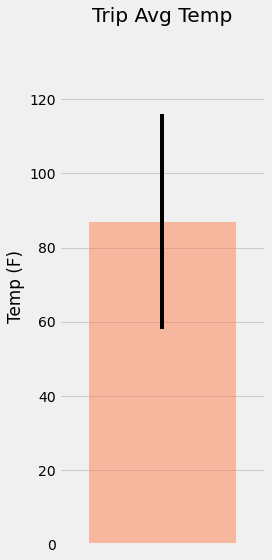

In [29]:
# Plot the min, max, avg in a bar graph with min and max showing as the error
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color='coral', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)
fig.tight_layout()

In [30]:
# Calculate the daily normals

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [31]:
june_prcpavg = np.mean(june_df['prcp'])
dec_prcpavg = np.mean(dec_df['prcp'])
print(june_prcpavg)
print(dec_prcpavg)

0.13635959339263018
0.21681850533807792


In [32]:
measurement_df.prcp.max()

11.53

In [62]:
month_list=measurement_df.index.month
month_list

Int64Index([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            ...
            8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
           dtype='int64', name='date', length=19550)

In [63]:
rain_df = measurement_df
rain_df

,id,station,prcp,tobs
date,,,,
2010-01-01,1,USC00519397,0.08,65.0
2010-01-02,2,USC00519397,0.00,63.0
2010-01-03,3,USC00519397,0.00,74.0
2010-01-04,4,USC00519397,0.00,76.0
2010-01-06,5,USC00519397,NaN,73.0
...,...,...,...,...
2017-08-19,19546,USC00516128,0.09,71.0
2017-08-20,19547,USC00516128,NaN,78.0
2017-08-21,19548,USC00516128,0.56,76.0


In [65]:
rain_df['month'] = month_list
rain_df

,id,station,prcp,tobs,month
date,,,,,
2010-01-01,1,USC00519397,0.08,65.0,1
2010-01-02,2,USC00519397,0.00,63.0,1
2010-01-03,3,USC00519397,0.00,74.0,1
2010-01-04,4,USC00519397,0.00,76.0,1
2010-01-06,5,USC00519397,NaN,73.0,1
...,...,...,...,...,...
2017-08-19,19546,USC00516128,0.09,71.0,8
2017-08-20,19547,USC00516128,NaN,78.0,8
2017-08-21,19548,USC00516128,0.56,76.0,8


In [66]:
rain_month_df = rain_df[['month', 'prcp']].copy()
rain_month_df

,month,prcp
date,,
2010-01-01,1,0.08
2010-01-02,1,0.00
2010-01-03,1,0.00
2010-01-04,1,0.00
2010-01-06,1,NaN
...,...,...
2017-08-19,8,0.09
2017-08-20,8,NaN
2017-08-21,8,0.56


In [67]:
for_plot = rain_month_df.groupby(by = ['month']).mean()
for_plot

,prcp
month,
1,0.129975
2,0.137271
3,0.204227
4,0.150639
5,0.145677
6,0.136360
7,0.167922
8,0.146662
9,0.164249


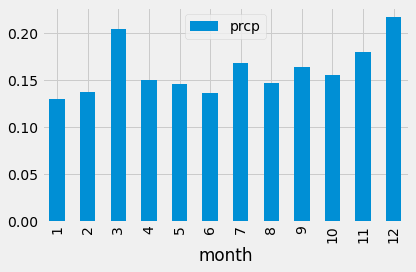

In [68]:
for_plot.plot.bar(y='prcp')
plt.tight_layout()
plt.savefig('Images/month_prcp.png')
plt.show()

In [72]:
start_date = '2016-12-12'
end_date = '2016-12-19'

sel = [Measurement.date, func.avg(Measurement.prcp)]

results = session.query(*sel).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Measurement.date).order_by(Measurement.date).all()

avg_prcp_dates = pd.DataFrame(
    results, columns = ['Date', 'Precipitation'])

avg_prcp_dates

,Date,Precipitation
0,2016-12-12,0.008333
1,2016-12-13,0.128333
2,2016-12-14,0.250000
3,2016-12-15,0.043333
4,2016-12-16,0.006667
5,2016-12-17,0.070000
6,2016-12-18,0.178000
7,2016-12-19,0.070000


In [73]:
# Calculate the total amount of rainfall per weather station for the trip. 

sel = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()

newdataframefordates = pd.DataFrame(
    results, columns = [
        'Station ID', 'Station', 'Latitude', 'Longitude', 'Elevation', 'Precipitation'])

newdataframefordates

,Station ID,Station,Latitude,Longitude,Elevation,Precipitation
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.39
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.80
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.65
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.61
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.57
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.24
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.02


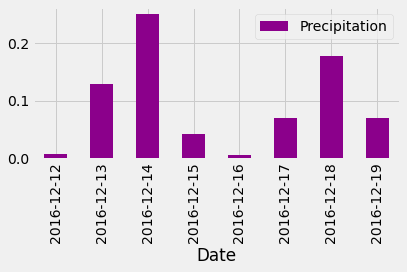

In [74]:
avg_prcp_dates.plot(kind = 'bar', color = 'darkmagenta').set_xlabel('Date')
plt.xticks([0,1,2,3,4,5,6,7], avg_prcp_dates.Date)
plt.tight_layout()
plt.savefig('Images/trip_prcp.png')
plt.show()

In [75]:
# calculate the daily normals for the trip

trip_dates = pd.date_range(start_date, end_date, freq='D')

trip_month_day = trip_dates.strftime('%m-%d')

normals = []
for date in trip_month_day:
    normals.append(*daily_normals(date))
    
normals

[(64.0, 70.88235294117646, 79.0),
 (65.0, 70.9423076923077, 80.0),
 (65.0, 71.18, 78.0),
 (62.0, 71.34, 79.0),
 (60.0, 69.62264150943396, 82.0),
 (63.0, 70.64, 77.0),
 (63.0, 71.28, 77.0),
 (67.0, 72.0, 78.0)]

In [76]:
# Create a dataframe
df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
df['date'] = trip_dates
df.set_index(['date'],inplace=True)
df.head()

,tmin,tavg,tmax
date,,,
2016-12-12,64.0,70.882353,79.0
2016-12-13,65.0,70.942308,80.0
2016-12-14,65.0,71.180000,78.0
2016-12-15,62.0,71.340000,79.0
2016-12-16,60.0,69.622642,82.0


Text(9.310000000000002, 0.5, 'Rainfall')

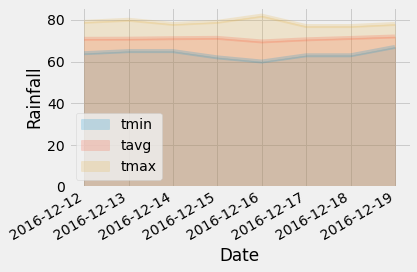

In [77]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area', stacked=False, x_compat=True, alpha=.2)
plt.tight_layout()
plt.xlabel("Date")
plt.ylabel("Rainfall")

# Close session

In [ ]:
# Close Session
session.close()